# CS 6045 Advanced Algorithms

# Optimization of connect4 game using Mini-Max Algorithm and Alpha-Beta Pruning

## Imported Libraries

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina', quality=100)
import numpy as np
import pandas as pd
import random
import pygame
import sys
import time
import math
from math import inf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Code Implementation 

In [2]:
%%time

# Input

Select_AI = input("Select the AI ('mini-max' or 'alpha-beta')?")

if Select_AI == "mini-max":
    DEPTH_VALUE = int(input("Enter depth value between 1 and 5?"))
if Select_AI == "alpha-beta":
    DEPTH_VALUE = int(input("Enter depth value between 1 and 8?"))
    
# Colors

GREY, LBLUE, DBLUE, WHITE, TEXT = (132,132,132), (61,89,171), (0,0,128), (255,255,240), (3,3,3)

# Grid Dimensions

HORI, VERT = 6, 7

# Utilizing Values

MAN, ALGO, MAN_CHANCE, ALGO_CHANCE  = 0, 1, 1, 2

# Defining weights

WEIGHT_MEASURE = 4
DUMMY = 0

# Function to Prepare an empty board
def game_grid():
    grid = np.zeros((HORI,VERT))
    return grid

# Sectioning the board
def drop_balls(grid, horizontal, vertical, ball):
    grid[horizontal][vertical] = ball

def true_loc(grid, vertical):
    return grid[HORI-1][vertical] == DUMMY

# Searching for vacant horizontal series
def check_next_vacant_row(grid, vertical):
    for ele in range(HORI):
        if grid[ele][vertical] == DUMMY:
            return ele

# Reverse the indexing of the board 
def print_grid(grid):
    print(np.flip(grid, DUMMY))

# -- Function defines connect4 game concept 
# -- checking the strikes for winning
def check_win_mov(grid, ball):
    # Checking win strikes in a row
    for v in range(VERT-3):
        for h in range(HORI):
            if grid[h][v] == ball and grid[h][v+1] == ball and grid[h][v+2] == ball and grid[h][v+3] == ball:
                return True
    # Checking win strikes in a column
    for v in range(VERT):
        for h in range(HORI-3):
            if grid[h][v] == ball and grid[h+1][v] == ball and grid[h+2][v] == ball and grid[h+3][v] == ball:
                return True
    # Checking win strikes in +ve sloped diagonals
    for v in range(VERT-3):
        for h in range(HORI-3):
            if grid[h][v] == ball and grid[h+1][v+1] == ball and grid[h+2][v+2] == ball and grid[h+3][v+3] == ball:
                return True

    # Checking win strikes in -ve sloped diagonals
    for v in range(VERT-3):
        for h in range(3, HORI):
            if grid[h][v] == ball and grid[h-1][v+1] == ball and grid[h-2][v+2] == ball and grid[h-3][v+3] == ball:
                return True
            
# Assigning the weights to make an action
def declare_weights(weight, ball):
    priority = DUMMY
    opponent_chance = MAN_CHANCE
    if ball == MAN_CHANCE:
        opponent_chance = ALGO_CHANCE
    if weight.count(ball) == 4:
        priority += 100
    elif weight.count(ball) == 3 and weight.count(DUMMY) == 1:
        priority += 5
    elif weight.count(ball) == 2 and weight.count(DUMMY) == 2:
        priority += 2
    if weight.count(opponent_chance) == 3 and weight.count(DUMMY) == 1:
        priority -= 4
    return priority

# Where to focus first(Traing AI to focus)?
def Preference_of_AI(grid, ball):
    priority = DUMMY
    # priority makes to choose center of the grid
    grid_middle_series = [int(k) for k in list(grid[:, VERT//2])]
    grid_middle_count = grid_middle_series.count(ball)
    priority += grid_middle_count * 3
    # prioritizing Horizontal
    for h in range(HORI):
        horizontal_series = [int(k) for k in list(grid[h,:])]
        for v in range(VERT-3):
            weight = horizontal_series[v:v+WEIGHT_MEASURE]
            priority += declare_weights(weight, ball)
    # prioritixing Vertical
    for v in range(VERT):
        vertical_series = [int(k) for k in list(grid[:,v])]
        for h in range(HORI-3):
            weight = vertical_series[h:h+WEIGHT_MEASURE]
            priority += declare_weights(weight, ball)
    # prioritizing +ve Diagonal
    for h in range(HORI-3):
        for v in range(VERT-3):
            weight = [grid[h+k][v+k] for k in range(WEIGHT_MEASURE)]
            priority += declare_weights(weight, ball)
    # prioritizing -ve Diagonal
    for h in range(HORI-3):
        for v in range(VERT-3):
            weight = [grid[h+3-k][v+k] for k in range(WEIGHT_MEASURE)]
            priority += declare_weights(weight, ball)
    return priority

def node(grid):
    return check_win_mov(grid, MAN_CHANCE) or check_win_mov(grid, ALGO_CHANCE) or len(get_certain_loc(grid)) == DUMMY

# Implementation of Mini-Max Algorithm(Our Bench-Mark Algorithm)
lis_mm, mm_column, mm_value = [], [], []
#@profile
def Mini_Max(grid, depth, maximizinggame):
    start_time = time.time()*1000.0
    certain_loc, term_head = get_certain_loc(grid), node(grid)
    if depth == 0 or term_head:
        if term_head:
            if check_win_mov(grid, ALGO_CHANCE):
                return (None, math.inf)
            elif check_win_mov(grid, MAN_CHANCE):
                return (None, -math.inf)
            else: #Game finished, No more valid moves
                return (None, DUMMY)
        else: #Depth is zero
            return (None, Preference_of_AI(grid, ALGO_CHANCE))
    if maximizinggame:
        value, column = -math.inf, random.choice(certain_loc)
        for vertical in certain_loc:
            horizontal, duplicate_grid = check_next_vacant_row(grid, vertical), grid.copy()
            drop_balls(duplicate_grid, horizontal, vertical, ALGO_CHANCE)
            new_priority = Mini_Max(duplicate_grid, depth-1, False)[1]
            if new_priority > value:
                value, column = new_priority, vertical
        mm_column.append(column)
        mm_value.append(value)
        return column, value
    else: #minimizinggame
        value = math.inf
        column = random.choice(certain_loc)
        for vertical in certain_loc:
            horizontal = check_next_vacant_row(grid, vertical)
            duplicate_grid = grid.copy()
            drop_balls(duplicate_grid, horizontal, vertical, MAN_CHANCE)
            new_priority = Mini_Max(duplicate_grid, depth-1, True)[1]
            if new_priority < value:
                value = new_priority
                column = vertical
        end_time = time.time()*1000.0
        lis_mm.append(end_time - start_time)
        mm_column.append(column)
        mm_value.append(value)
        return column, value

# Implementation of Alpha_Beta Algorithm(Our Optimal Algorithm)
lis_ab, ab_column, ab_value = [], [], []
#@profile
def alpha_beta(grid, depth, alpha, beta, maximizingPlayer):
    start_time = time.time()*1000.0
    valid_locations = get_certain_loc(grid)
    is_terminal = node(grid)
    if depth == 0 or is_terminal:
        if is_terminal:
            if check_win_mov(grid, ALGO_CHANCE):
                return (None, math.inf)
            elif check_win_mov(grid, MAN_CHANCE):
                return (None, -math.inf)
            else: #Game finished, No more valid moves
                return (None, DUMMY)
        else: # Depth is zero
            return (None, Preference_of_AI(grid, ALGO_CHANCE))
    if maximizingPlayer:
        value = -math.inf
        vert_col = random.choice(valid_locations)
        for vertical in valid_locations:
            horizontal = check_next_vacant_row(grid, vertical)
            b_copy = grid.copy()
            drop_balls(b_copy, horizontal, vertical, ALGO_CHANCE)
            new_priority = alpha_beta(b_copy, depth-1, alpha, beta, False)[1]
            if new_priority > value:
                value = new_priority
                vert_col = vertical
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        ab_column.append(vert_col)
        ab_value.append(vert_col)
        return vert_col, value
    else: # Minimizing component
        value = math.inf
        vert_col = random.choice(valid_locations)
        for vertical in valid_locations:
            horizontal = check_next_vacant_row(grid, vertical)
            b_copy = grid.copy()
            drop_balls(b_copy, horizontal, vertical, MAN_CHANCE)
            new_priority = alpha_beta(b_copy, depth-1, alpha, beta, True)[1]
            if new_priority < value:
                value = new_priority
                vert_col = vertical
            beta = min(beta, value)
            if alpha >= beta:
                break
        end_time = time.time()*1000.0
        lis_ab.append(end_time - start_time)
        return vert_col, value

def get_certain_loc(grid):
    certain_loc = [(vertical) for vertical in range(VERT) if true_loc(grid, vertical)]
    return certain_loc

# Function to predict moves(priority selection)
def optimal_prediction_mov(grid, ball):
    efficient_priority = -12022
    efficient_series = random.choice(get_certain_loc(grid))
    for vertical in get_certain_loc(grid):
        horizontal = check_next_vacant_row(grid, vertical)
        temp_grid = grid.copy()
        drop_balls(temp_grid, horizontal, vertical, ball)
        priority = Preference_of_AI(temp_grid, ball)
        if priority > efficient_priority:
            efficient_priority = priority
            efficient_series = vertical
    return efficient_series

# Function to creat the grid according to my screen size.
def draw_grid(grid):
    for v in range(VERT):
        for h in range(HORI):
            pygame.draw.rect(screen, GREY, (v*weigh, h*weigh+weigh, weigh, weigh))
            pygame.draw.circle(screen, LBLUE, (int(v*weigh+weigh/2), int(h*weigh+weigh+weigh/2)), RADIUS)
    for v in range(VERT):
        for h in range(HORI):      
            if grid[h][v] == MAN_CHANCE:
                pygame.draw.circle(screen, DBLUE, (int(v*weigh+weigh/2), Length-int(h*weigh+weigh/2)), RADIUS)
            elif grid[h][v] == ALGO_CHANCE: 
                pygame.draw.circle(screen, WHITE, (int(v*weigh+weigh/2), Length-int(h*weigh+weigh/2)), RADIUS)
    pygame.display.update()

# Variables Declaration
grid = game_grid()
print_grid(grid)
end_game = False

pygame.init()

weigh = 100

breadth = VERT * weigh
Length = (HORI+1) * weigh

size = (breadth, Length)

RADIUS = int(weigh/2 - 5)

screen = pygame.display.set_mode(size)
draw_grid(grid)
pygame.display.update()

myfont = pygame.font.SysFont("monospace", 75)

chance = random.randint(MAN, ALGO)

# Logic Intialization
while not end_game:
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            sys.exit()
            
        if event.type == pygame.MOUSEMOTION:
            pygame.draw.rect(screen, LBLUE, (0,0, breadth, weigh))
            position = event.pos[0]
            
            if chance == MAN:
                pygame.draw.circle(screen, DBLUE, (position, int(weigh/2)), RADIUS)
                
        pygame.display.update()
        
        if event.type == pygame.MOUSEBUTTONDOWN:
            pygame.draw.rect(screen, LBLUE, (0,0, breadth, weigh))
            if chance == MAN:
                position = event.pos[0]
                vertical = int(math.floor(position/weigh))
                if true_loc(grid, vertical):
                    horizontal = check_next_vacant_row(grid, vertical)
                    drop_balls(grid, horizontal, vertical, MAN_CHANCE)

                    if check_win_mov(grid, MAN_CHANCE):
                        label = myfont.render("Blue wins!!", 1, DBLUE)
                        screen.blit(label, (20,10))
                        end_game = True
                    chance += 1
                    chance = chance % 2
                    print_grid(grid)
                    draw_grid(grid)
                    
        if Select_AI == "mini-max":
            if chance == ALGO and not end_game:
                vertical, Mini_Max_priority = Mini_Max(grid, DEPTH_VALUE, True)
                if true_loc(grid, vertical):
                    pygame.time.wait(143)
                    horizontal = check_next_vacant_row(grid, vertical)
                    drop_balls(grid, horizontal, vertical, ALGO_CHANCE)
                    if check_win_mov(grid, ALGO_CHANCE):
                        label = myfont.render("White Wins!!", 1, WHITE)
                        screen.blit(label, (20, 10))
                        end_game = True
                    print_grid(grid)
                    draw_grid(grid)
                    chance += MAN_CHANCE
                    chance = chance % ALGO_CHANCE
            if end_game:
                pygame.time.wait(2022)

        if Select_AI == "alpha-beta":
            if chance == ALGO and not end_game:                
                vertical, alpha_beta_priority = alpha_beta(grid, DEPTH_VALUE, -math.inf, math.inf, True)
                if true_loc(grid, vertical):
                    #pygame.time.wait(500)
                    horizontal = check_next_vacant_row(grid, vertical)
                    drop_balls(grid, horizontal, vertical, ALGO_CHANCE)
                    if check_win_mov(grid, ALGO_CHANCE):
                        label = myfont.render("White wins!!", 1, WHITE)
                        screen.blit(label, (40,10))
                        end_game = True
                    print_grid(grid)
                    draw_grid(grid)
                    chance += 1
                    chance = chance % 2
            if end_game:
                pygame.time.wait(2022)

if Select_AI == "mini-max":
    try:
        t1 = sum(lis_mm)/len(lis_mm)
    except ZeroDivisionError:
        t1 = 0
    print()
    print("Gathering 'Mini-Max' Data to analyse 'Compilation Time':")
    print()
    print("Mini-Max time for depth value", DEPTH_VALUE, "is", round(t1, 3), "milliseconds")
    print()
    print("Gathering 'Mini-Max' Data to calculate 'Accuracy':")
    print()
    minimax_return = pd.DataFrame({"Minimax Column":mm_column, "Minimax Weight":mm_value})
    minimax_return[minimax_return == -inf], minimax_return[minimax_return == inf] = 0, 100
    acc_data_mm = minimax_return.groupby("Minimax Column").sum()
    print(acc_data_mm)
    print()
    print("Mini-Max Algorithm resultant data as putting weights for each column at depth", DEPTH_VALUE, ":", 
          acc_data_mm['Minimax Weight'].tolist())
    print()
    
if Select_AI == "alpha-beta":
    try:
        t2 = sum(lis_ab)/len(lis_ab)
    except ZeroDivisionError:
        t2 = 0
    print()
    print("Gathering 'Alpha-Beta' Data to analyse 'Compilation Time':")
    print()
    print("Alpha-Beta time for depth value", DEPTH_VALUE, "is", round(t2, 3), "milliseconds")
    print()
    print("Gathering 'Alpha-Beta' Data to calculate 'Accuracy':")
    print()
    alphabeta_return = pd.DataFrame({"Alphabeta Column":ab_column, "Alphabeta Weight":ab_value})
    alphabeta_return[alphabeta_return == -inf], alphabeta_return[alphabeta_return == inf] = 0, 100
    acc_data_ab = alphabeta_return.groupby("Alphabeta Column").sum()
    print(acc_data_ab)
    print()
    print("Alpha-Beta Algorithm resultant data as putting weights for each column at depth", DEPTH_VALUE, ":", 
          acc_data_ab['Alphabeta Weight'].tolist())
    print()

Select the AI ('mini-max' or 'alpha-beta')?alpha-beta
Enter depth value between 1 and 8?3
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 2. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 1. 2. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 1. 2. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 2. 2. 0. 0. 0.]
 [0. 0. 1. 2. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

# Time Graphs

## Mini-Max & Alpha-Beta Time Datasets

In [3]:
minimax_time_dataset = pd.read_csv("Mini-Max Time Data.csv")
alphabeta_time_dataset = pd.read_csv("Alpha-Beta Time Data.csv")

In [4]:
minimax_time_dataset

,Mini-Max Input,Mini-Max Time
0,1,0.000
1,1,0.000
2,1,0.000
3,1,0.000
4,1,0.000
5,1,0.000
6,1,0.000
7,1,0.000
8,1,0.000
9,1,0.000


In [5]:
alphabeta_time_dataset

,Alpha-Beta Input,Alpha-Beta Time
0,1,0.000
1,1,0.000
2,1,0.000
3,1,0.000
4,1,0.000
...,...,...
65,7,18.339
66,7,16.884
67,7,15.482
68,7,14.950


## Mini-Max Time Graph

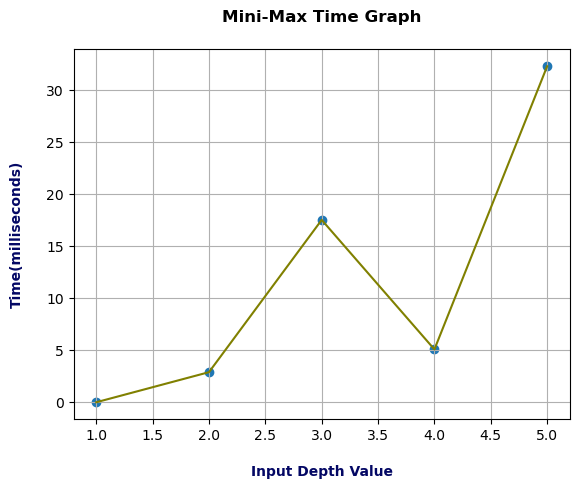

In [23]:
fig, ax = plt.subplots()
res_minimax = pd.DataFrame(minimax_time_dataset.groupby("Mini-Max Input").mean())
res_minimax.reset_index(inplace = True)
res_minimax.columns = ('Inp','Time')
plt.rcdefaults()
plt.plot(res_minimax['Inp'], res_minimax['Time'], color = 'Olive')
plt.xlabel("Input Depth Value", color = '#030764', labelpad = 16, weight = 'bold')
plt.ylabel("Time(milliseconds)", color = '#030764', labelpad = 16, weight = 'bold')
plt.title('Mini-Max Time Graph', color = 'Black', pad = 20, weight = 'bold')
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.scatter(res_minimax['Inp'], res_minimax['Time'])
plt.show()

## Alpha-Beta Time Graph

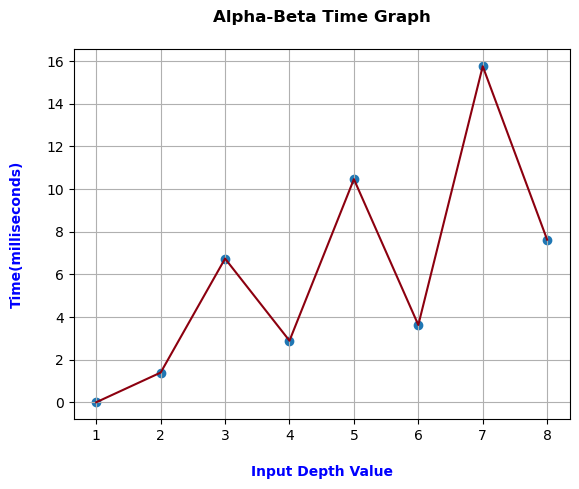

In [7]:
fig, ax = plt.subplots()
res_alphabeta = pd.DataFrame(alphabeta_time_dataset.groupby("Alpha-Beta Input").mean())
res_alphabeta.reset_index(inplace = True)
res_alphabeta.columns = ('Inp','Time')
plt.rcdefaults()
plt.plot(res_alphabeta['Inp'], res_alphabeta['Time'], color = '#8c000F')
plt.xlabel("Input Depth Value", color = 'Blue', labelpad = 16, weight = 'bold')
plt.ylabel("Time(milliseconds)", color = 'Blue', labelpad = 16, weight = 'bold')
plt.title('Alpha-Beta Time Graph', color = 'Black', pad = 20, weight = 'bold')
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.scatter(res_alphabeta['Inp'], res_alphabeta['Time'])
plt.show()

## Mini-Max & Alpha-Beta Time Graph Comparison

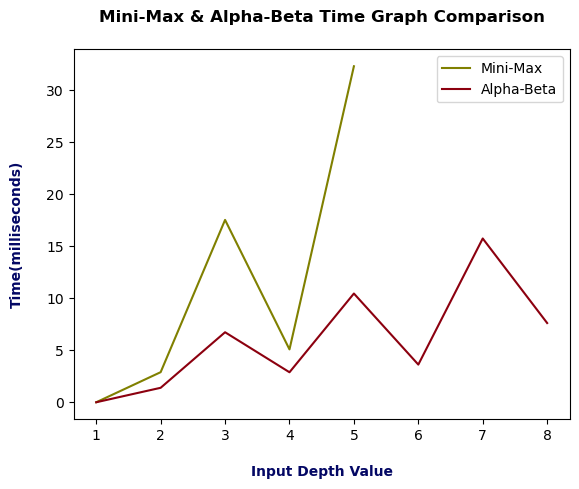

In [8]:
plt.rcdefaults()
plt.plot(res_minimax['Inp'], res_minimax['Time'], label = "Mini-Max", color = 'Olive')
# plt.scatter(res_minimax['Inp'], res_minimax['Time'])
plt.plot(res_alphabeta['Inp'], res_alphabeta['Time'], label = "Alpha-Beta", color = '#8c000F')
# plt.scatter(res_alphabeta['Inp'], res_alphabeta['Time'])
plt.xlabel("Input Depth Value", color = '#030764', labelpad = 16, weight = 'bold')
plt.ylabel("Time(milliseconds)", color = '#030764', labelpad = 16, weight = 'bold')
plt.title('Mini-Max & Alpha-Beta Time Graph Comparison', color = 'Black', pad = 20, weight = 'bold')
plt.legend()
plt.show()

# Space Allocation

# Mini-Max & Alpha-Beta Space Datasets

In [9]:
minimax_space_dataset = pd.read_csv("Mini-Max Space Data.csv")
alphabeta_space_dataset = pd.read_csv("Alpha-Beta Space Data.csv")

In [10]:
minimax_space_dataset

,Mini-Max Input Depth,Space Required
0,1,99.387
1,1,99.332
2,1,99.371
3,1,99.387
4,1,99.263
5,1,99.355
6,1,99.327
7,1,99.258
8,1,99.236
9,1,99.312


In [11]:
alphabeta_space_dataset

,Alpha-Beta Input Depth,Space Allocation
0,1,99.578
1,1,99.523
2,1,99.545
3,1,99.550
4,1,99.533
...,...,...
75,8,99.999
76,8,101.241
77,8,101.471
78,8,101.671


# Mini-Max Space Allocation Graph

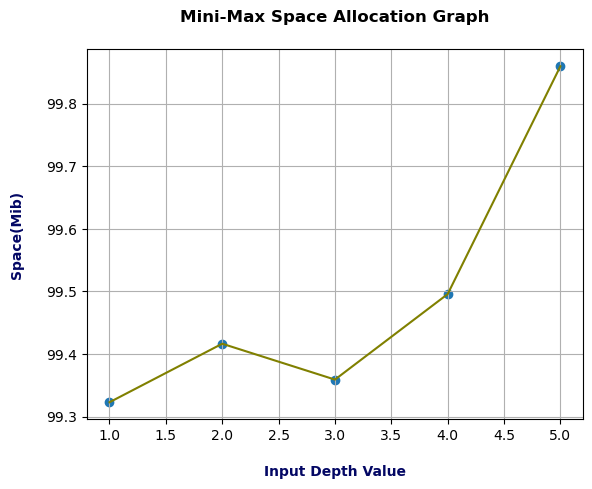

In [12]:
fig, ax = plt.subplots()
res_minimax_space = pd.DataFrame(minimax_space_dataset.groupby("Mini-Max Input Depth").mean())
res_minimax_space.reset_index(inplace = True)
res_minimax_space.columns = ('Inp','Space')
plt.rcdefaults()
plt.plot(res_minimax_space['Inp'], res_minimax_space['Space'], color = 'Olive')
plt.xlabel("Input Depth Value", color = '#030764', labelpad = 16, weight = 'bold')
plt.ylabel("Space(Mib)", color = '#030764', labelpad = 16, weight = 'bold')
plt.title('Mini-Max Space Allocation Graph', color = 'Black', pad = 20, weight = 'bold')
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.scatter(res_minimax_space['Inp'], res_minimax_space['Space'])
plt.show()

# Alpha-Beta Space Allocation Graph

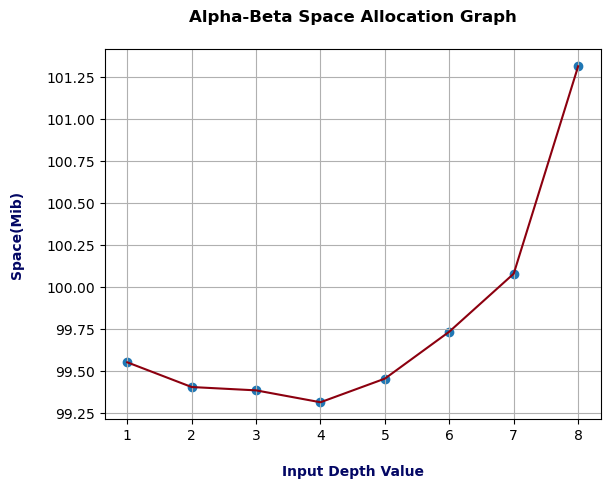

In [13]:
fig, ax = plt.subplots()
res_alphabeta_space = pd.DataFrame(alphabeta_space_dataset.groupby("Alpha-Beta Input Depth").mean())
res_alphabeta_space.reset_index(inplace = True)
res_alphabeta_space.columns = ('Inp','Space')
plt.rcdefaults()
plt.plot(res_alphabeta_space['Inp'], res_alphabeta_space['Space'], color = '#8c000F')
plt.xlabel("Input Depth Value", color = '#030764', labelpad = 16, weight = 'bold')
plt.ylabel("Space(Mib)", color = '#030764', labelpad = 16, weight = 'bold')
plt.title('Alpha-Beta Space Allocation Graph', color = 'Black', pad = 20, weight = 'bold')
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.scatter(res_alphabeta_space['Inp'], res_alphabeta_space['Space'])
plt.show()

# Mini-Max & Alpha-Beta Space Allocation Comparison

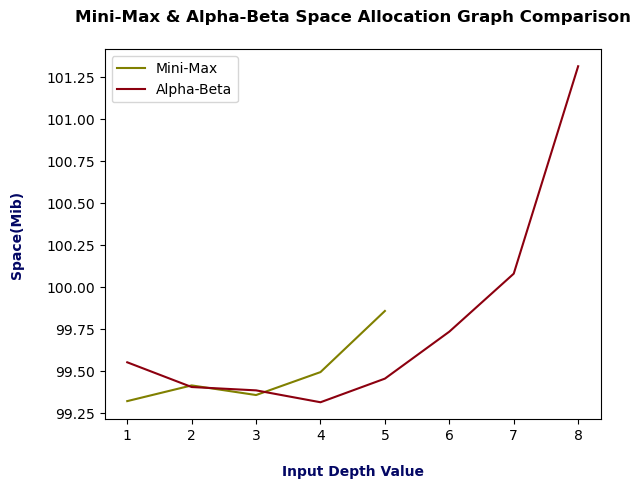

In [14]:
plt.rcdefaults()
plt.plot(res_minimax_space['Inp'], res_minimax_space['Space'], label = "Mini-Max", color = 'Olive')
# plt.scatter(res_minimax['Inp'], res_minimax['Time'])
plt.plot(res_alphabeta_space['Inp'], res_alphabeta_space['Space'], label = "Alpha-Beta", color = '#8c000F')
# plt.scatter(res_alphabeta['Inp'], res_alphabeta['Time'])
plt.xlabel("Input Depth Value", color = '#030764', labelpad = 16, weight = 'bold')
plt.ylabel("Space(Mib)", color = '#030764', labelpad = 16, weight = 'bold')
plt.title('Mini-Max & Alpha-Beta Space Allocation Graph Comparison', color = 'Black', pad = 20, weight = 'bold')
plt.legend()
plt.show()

# Acuracy

## Mini-Max & Alpha-Beta Accuracy Datasets

In [15]:
minimax_acc_dataset = pd.read_csv("Mini-Max Accuracy Data.csv")
alphabeta_acc_dataset = pd.read_csv("Alpha-Beta Accuracy Data.csv")

In [16]:
minimax_acc_dataset

,Mini-Max Input,Col1,Col2,Col3,Col4,Col5,Col6,Col7
0,1,14.0,525.0,33.0,179.0,195.0,270.0,0.0
1,1,13.0,51.0,220.0,76.0,141.0,392.0,135.0
2,1,12.0,100.0,32.0,9.0,120.0,100.0,0.0
3,1,16.0,100.0,30.0,17.0,131.0,210.0,0.0
4,1,18.0,67.0,52.0,44.0,41.0,200.0,0.0
5,1,19.0,0.0,152.0,47.0,173.0,167.0,0.0
6,1,10.0,0.0,67.0,47.0,139.0,140.0,0.0
7,1,14.0,525.0,33.0,179.0,195.0,27.0,0.0
8,1,10.0,0.0,67.0,47.0,139.0,140.0,0.0
9,1,20.0,168.0,172.0,170.0,136.0,57.0,59.0


In [17]:
alphabeta_acc_dataset

,Alpha-Beta Input,Col1,Col2,Col3,Col4,Col5,Col6,Col7
0,1,14.0,525.0,33.0,179.0,195.0,270.0,100.0
1,1,13.0,51.0,220.0,76.0,141.0,392.0,135.0
2,1,12.0,100.0,32.0,9.0,120.0,100.0,168.0
3,1,16.0,100.0,30.0,17.0,131.0,210.0,0.0
4,1,18.0,67.0,52.0,44.0,41.0,200.0,0.0
...,...,...,...,...,...,...,...,...
75,8,11182.0,21682.0,11400.0,81186.0,52152.0,9350.0,11314.0
76,8,21182.0,10782.0,25480.0,79308.0,42152.0,10370.0,1474.0
77,8,10182.0,20882.0,19630.0,80499.0,40552.0,12300.0,11434.0
78,8,24182.0,10982.0,29720.0,50650.0,40652.0,9300.0,1414.0


## Mini-Max Accuracy Caluclation 

In [18]:
from sklearn.linear_model import LinearRegression
mm_y = minimax_acc_dataset.iloc[:,0:1].values
mm_X = minimax_acc_dataset.iloc[:, 1:].values
mm_X_train, mm_X_test, mm_y_train, mm_y_test = train_test_split(mm_X, mm_y, test_size = 0.25, random_state = 0)
sc = StandardScaler()
mm_X_train = sc.fit_transform(mm_X_train)
mm_X_test = sc.transform(mm_X_test)
classifier = LogisticRegression(random_state = 0)
classifier.fit(mm_X_train, mm_y_train)
mm_y_pred = classifier.predict(mm_X_test)
cm = confusion_matrix(mm_y_test, mm_y_pred)
#print(cm)
print("Accuracy of Mini-Max Implementation:", accuracy_score(mm_y_test, mm_y_pred)*100, "%")

Accuracy of Mini-Max Implementation: 84.61538461538461 %


C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Alpha-Beta Accuracy Calculation

In [19]:
ab_y = alphabeta_acc_dataset.iloc[:,0:1].values
ab_X = alphabeta_acc_dataset.iloc[:, 1:].values
ab_X_train, ab_X_test, ab_y_train, ab_y_test = train_test_split(ab_X, ab_y, test_size = 0.25, random_state = 0)
sc = StandardScaler()
ab_X_train = sc.fit_transform(ab_X_train)
ab_X_test = sc.transform(ab_X_test)
classifier = LogisticRegression(random_state = 0)
classifier.fit(ab_X_train, ab_y_train)
ab_y_pred = classifier.predict(ab_X_test)
cm = confusion_matrix(ab_y_test, ab_y_pred)
#print(cm)
print("Accuracy of Mini-Max Implementation:", accuracy_score(ab_y_test, ab_y_pred)*100, "%")

Accuracy of Mini-Max Implementation: 85.0 %


C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [20]:
print("Accuracy of Mini-Max Implementation:", round(accuracy_score(mm_y_test, mm_y_pred)*100,3), "%")

Accuracy of Mini-Max Implementation: 84.615 %


In [21]:
print("Accuracy of Alpha-Beta Implementation:", round(accuracy_score(ab_y_test, ab_y_pred)*100,3), "%")

Accuracy of Alpha-Beta Implementation: 85.0 %


# Accuracy Comparison 

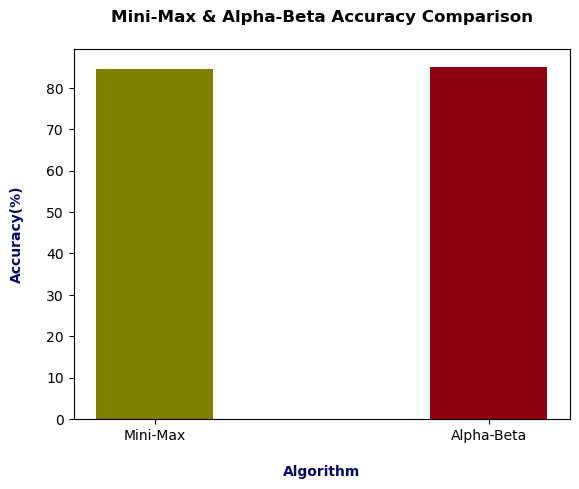

In [22]:
Method = ["Mini-Max", "Alpha-Beta"]
Accuracy = [round(accuracy_score(mm_y_test, mm_y_pred)*100,3), round(accuracy_score(ab_y_test, ab_y_pred)*100,3)]
plt.rcdefaults()
plt.bar(Method, Accuracy, width = 0.35, align = "center", color = ['Olive', '#8c000F'])
plt.title("Mini-Max & Alpha-Beta Accuracy Comparison", pad = 20, weight = 'bold')
plt.xlabel("Algorithm", color = "#030764", labelpad = 16, weight = 'bold')
plt.ylabel("Accuracy(%)", color ="#030764", labelpad = 16, weight = 'bold')
plt.show()

# Conclusion
## Both algorithms should give the same answer. However, their main difference is that alpha-beta does not explore all paths, like minimax does, but prunes those that are guaranteed not to be an optimal state for the current player, that is max or min. So, alpha-beta is a better implementation of minimax.